# Classification of Pnemonia Cases using PneumoniaMNIST

In [1]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import medmnist
from torchvision.transforms import transforms

In [15]:
train_data = medmnist.PneumoniaMNIST(split='train', download=True, transform=transforms.ToTensor())
val_data = medmnist.PneumoniaMNIST(split='val', download=True, transform=transforms.ToTensor())
test_data = medmnist.PneumoniaMNIST(split='test', download=True, transform=transforms.ToTensor())

Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz
Using downloaded and verified file: /root/.medmnist/pneumoniamnist.npz


Visual Data Analysis

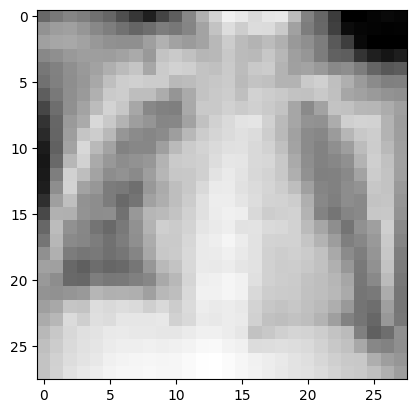

In [16]:
for img, t in train_data:

  img = img.numpy()
  img = img.transpose(1, 2, 0)
  plt.imshow(img, cmap='gray')
  break

Analysing images with and without pneumonia

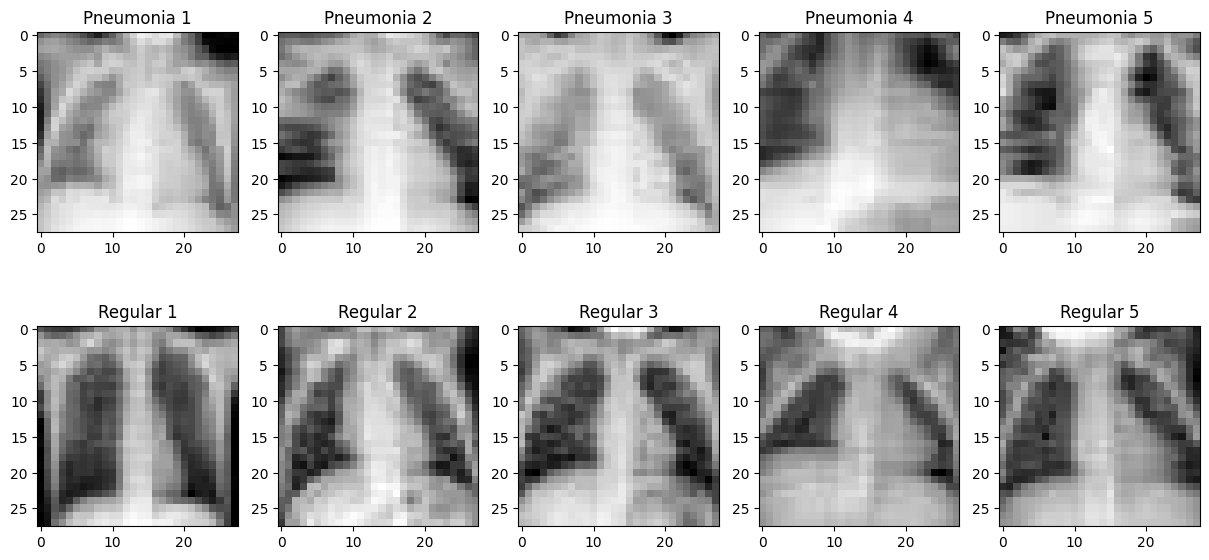

In [20]:
p_images = [] # pneumonia images
r_images = [] # regular images

for img, t in train_data:
  if t == 1 and len(p_images) < 5:
    p_images.append(img)
  elif t == 0 and len(r_images) < 5:
    r_images.append(img)

  if len(p_images) == 5 and len(r_images) == 5:
    break

# display the images in subplots using plt

fig, axs = plt.subplots(2, 5, figsize=(15, 7))

for i in range(5):
  axs[0, i].imshow(p_images[i].numpy().transpose(1, 2, 0), cmap='gray')
  axs[0, i].set_title(f'Pneumonia {i+1}')
  axs[1, i].imshow(r_images[i].numpy().transpose(1, 2, 0), cmap='gray')
  axs[1, i].set_title(f'Regular {i+1}')

# plt.tight_layout()

plt.show()

In [18]:
print(len(train_data), len(val_data), len(test_data))

4708 524 624
